In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import emcee
import corner

In [10]:
df = pd.read_csv('/Users/orion/RDaly2023/mcmc-fitting/Zhu_Rakshit_flagged_final367.csv', 
                 header=0, usecols=[0,1,4,5,8,9])
df

,SDSS Name,z_1,Log(L_5 GHz),Log(2 keV),logMBH,e_logMBH
0,000442.18+000023.3,1.008,32.09,26.91,9.281283,0.031152
1,000622.60-000424.4,1.038,34.94,27.32,8.823198,0.059579
2,001646.54-005151.7,2.243,32.66,26.36,9.011771,0.240900
3,001910.95+034844.6,2.022,32.91,26.54,8.696172,0.037866
4,003054.63+045908.4,2.201,33.81,26.59,8.688945,0.189143
...,...,...,...,...,...,...
362,222852.60-075346.6,0.638,33.12,26.83,8.546475,0.068004
363,231156.65+015324.5,2.257,32.54,26.34,8.784155,0.118988
364,232734.73+002234.0,1.494,33.56,26.96,9.709295,0.111279
365,234808.62+020725.8,1.872,32.84,26.61,9.817211,0.082521


In [11]:
df.rename(columns={'z_1':'z', 'Log(L_5 GHz)':'logR', 'Log(2 keV)': 'logX'}, inplace=True)

In [14]:
#df['1+z'] = 1+df['z']
df['logz+1'] = np.log10(1+df['z'])
df

,SDSS Name,z,logR,logX,logMBH,e_logMBH,logz+1
0,000442.18+000023.3,1.008,32.09,26.91,9.281283,0.031152,0.302764
1,000622.60-000424.4,1.038,34.94,27.32,8.823198,0.059579,0.309204
2,001646.54-005151.7,2.243,32.66,26.36,9.011771,0.240900,0.510947
3,001910.95+034844.6,2.022,32.91,26.54,8.696172,0.037866,0.480294
4,003054.63+045908.4,2.201,33.81,26.59,8.688945,0.189143,0.505286
...,...,...,...,...,...,...,...
362,222852.60-075346.6,0.638,33.12,26.83,8.546475,0.068004,0.214314
363,231156.65+015324.5,2.257,32.54,26.34,8.784155,0.118988,0.512818
364,232734.73+002234.0,1.494,33.56,26.96,9.709295,0.111279,0.396896
365,234808.62+020725.8,1.872,32.84,26.61,9.817211,0.082521,0.458184


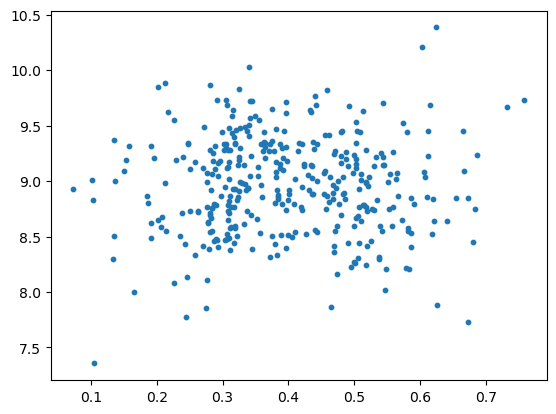

In [15]:
plt.scatter(df['logz+1'], df['logMBH'], s=10)


# no apparent trend of Mbh with redshift -- so we should be fine

In [17]:
def statmodel_fit(x, y):

    x = sm.add_constant(x) # adding a constant
 
    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 
 
    print_model = model.summary()
    print(print_model)
    

In [18]:
#                                3-parameter model:    y = a.x1 + b.x2 + c.x3 + const
#                                              y = L_r   ,   x1 = L_x   ,   x2 = M_bh   ,    x3 = (1+z)

In [19]:
xaxis = df[['logX','logMBH','logz+1']]
yaxis = df['logR']

In [21]:
statmodel_fit(xaxis, yaxis)

                            OLS Regression Results                            
Dep. Variable:                   logR   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     107.2
Date:                Sun, 04 Jun 2023   Prob (F-statistic):           1.06e-49
Time:                        01:07:59   Log-Likelihood:                -338.43
No. Observations:                 367   AIC:                             684.9
Df Residuals:                     363   BIC:                             700.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0847      1.941      2.620      0.0

In [22]:
#true values --> using OLP fit as initial guesses 

m1_true = 1.0825
m2_true = -0.1693
m3_true = 1.4744
const = 5.0847
f_true = 0.500   # random guess 

In [23]:
# 1sigma as error bar

df['logX_err'] = df['logX'].std()
#df['logR_err'] = df['logR'].std()

In [24]:
x = df[['logX','logMBH','logz+1']]
y = df['logR']

yerr = np.sqrt(df['logX_err']**2 + df['e_logMBH']**2)

# NOT USING ANY ERROR IN (1+z)

In [25]:
def log_likelihood(theta, x1, x2, x3, y, yerr):
    m1, m2, m3, c, log_f = theta
    model = m1*x1 + m2*x2 + m3*x3 + c              
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [26]:
x1 = x.to_numpy()[:,0]   
x2 = x.to_numpy()[:,1]
x3 = x.to_numpy()[:,2]

In [28]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m1_true, m2_true, m3_true, const, np.log(f_true)]) + 0.1 * np.random.randn(5)
soln = minimize(nll, initial, args=(x1, x2, x3, y, yerr))
m1_ml, m2_ml, m3_ml, const_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(m1_ml))
print("b = {0:.3f}".format(m2_ml))
print("c = {0:.3f}".format(m3_ml))
print("const = {0:.3f}".format(const_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))     


Maximum likelihood estimates:
a = 1.093
b = -0.187
c = 1.431
const = 4.971
f = 0.011


In [ ]:
# MCMC error estimation


#Maximum likelihood estimates:
#a = 1.093
#b = -0.187
#c = 1.431
#const = 4.971
#f = 0.011

In [47]:
def log_prior(theta):
    m1, m2, m3, c, log_f = theta
    if -5.0 < m1 < 5.0 and -5.0 < m2 < 5.0 and -5.0 < m3 < 5.0 and -2.0 < c < 10.0 and -5.0 < log_f < 5.0:
                            # use max-likelihood fit results to predict the range of params
        return 0.0
    return -np.inf

def log_probability(theta, x1, x2, x3, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x1, x2, x3, y, yerr)


In [37]:
pos = soln.x + 0.05 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

print(nwalkers, ndim)

32 5


In [48]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x1, x2, x3, y, yerr)
)

sampler.run_mcmc(pos, 500, progress=True);          #the colon prevents hidden print command apparently

100%|██████████████████████████████████████████████| 500/500 [00:09<00:00, 52.46it/s]


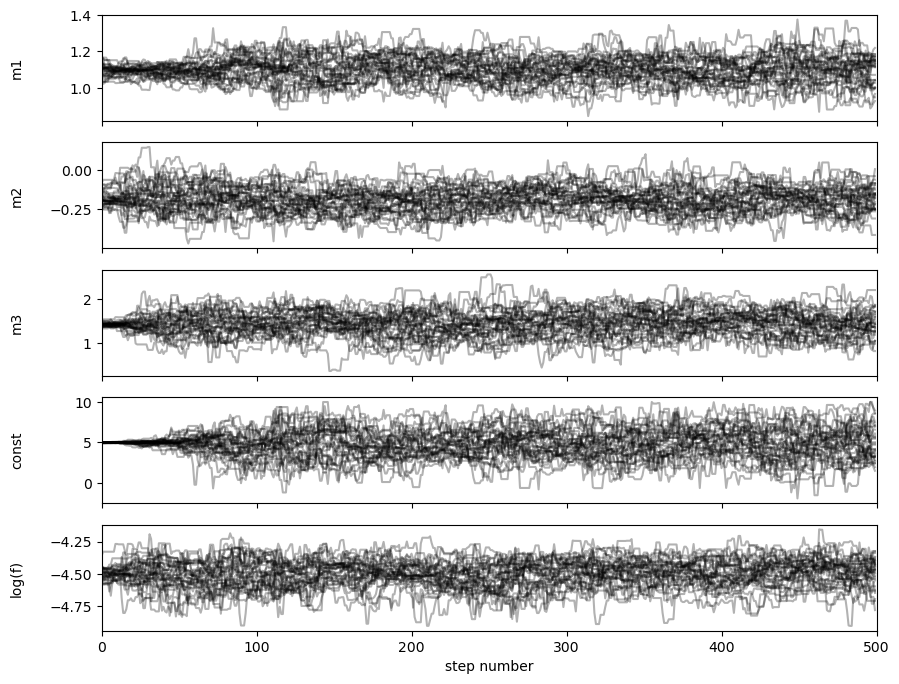

In [49]:
fig, axes = plt.subplots(5, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["m1", "m2", "m3", "const", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [51]:
sampler.reset()
sampler.run_mcmc(pos, 5000, progress=True);

100%|████████████████████████████████████████████| 5000/5000 [01:35<00:00, 52.58it/s]


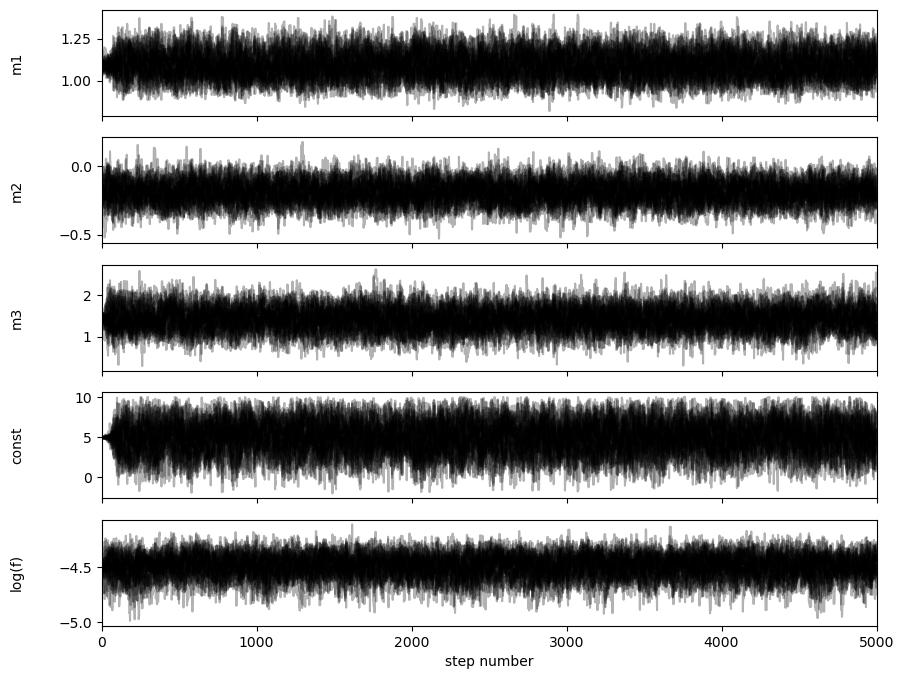

In [52]:
fig, axes = plt.subplots(5, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["m1", "m2", "m3", "const", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [54]:
tau = sampler.get_autocorr_time()
print(tau)

[54.94277315 51.93587756 54.96211532 55.00295013 48.33120821]


In [55]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 5)


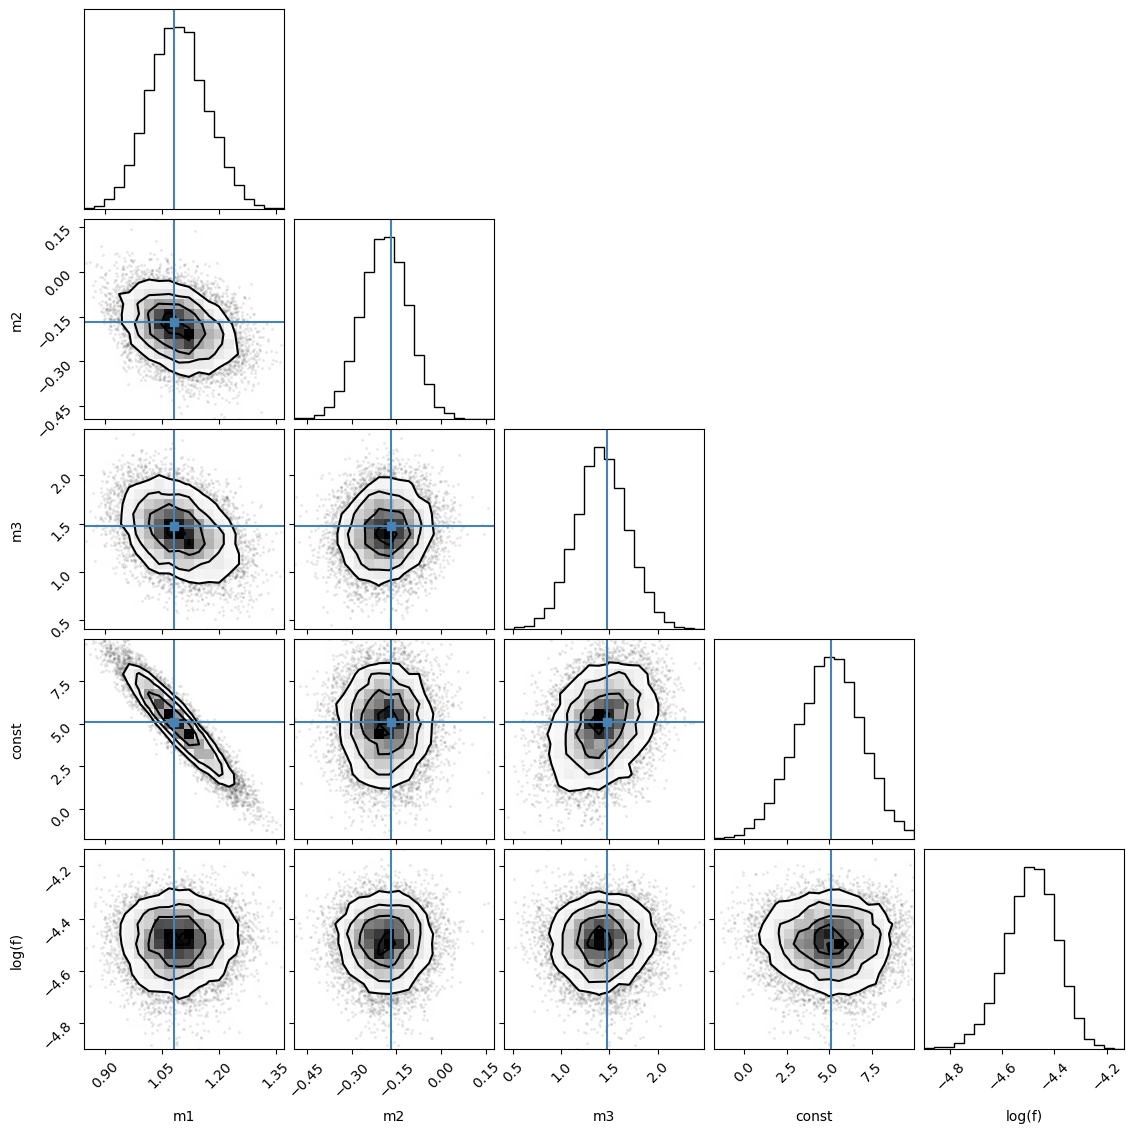

In [56]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m1_true, m2_true, m3_true, const, np.log(f_true)]
)

In [57]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
print(sample)

[ 1.08318649 -0.14727637  1.28417741  4.92580637 -4.42455815]


In [ ]:
for ind in inds:
    sample = flat_samples[ind]
    print(sample)

In [62]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>